# Loading Necessary Packages

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn; 
from scipy import stats
import pylab as pl
from sklearn.metrics import mean_squared_error, r2_score
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
import os
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [107]:
df = pd.read_csv("updated_flight_data_and_price_history_iah_to_SAT.csv")

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    311 non-null    object 
 1   Price   311 non-null    float64
 2   Route   61 non-null     object 
 3   From    250 non-null    object 
dtypes: float64(1), object(3)
memory usage: 9.8+ KB


In [109]:
df.head()

,Date,Price,Route,From
0,26-12-2023 06:00,69.0,IAH,NaN
1,27-12-2023 06:00,69.0,IAH,NaN
2,28-12-2023 06:00,69.0,IAH,NaN
3,29-12-2023 06:00,70.0,IAH,NaN
4,30-12-2023 06:00,70.0,IAH,NaN


# Creating function for plotting volatility of price over time

In [110]:
def plot_price_volatility(stock_df, window):
    daily_returns = stock_df['Price'].pct_change()
    
    rolling_std = daily_returns.rolling(window=window).std()
    
    plt.figure(figsize=(12, 6))
    rolling_std.plot()
    plt.title(f'Volatility of Price (Rolling {window}-Day Std Dev)')
    plt.xlabel('Date')
    plt.ylabel('Volatility (Std Dev)')
    plt.grid(True)
    plt.show()
    ##st.pyplot(plt)

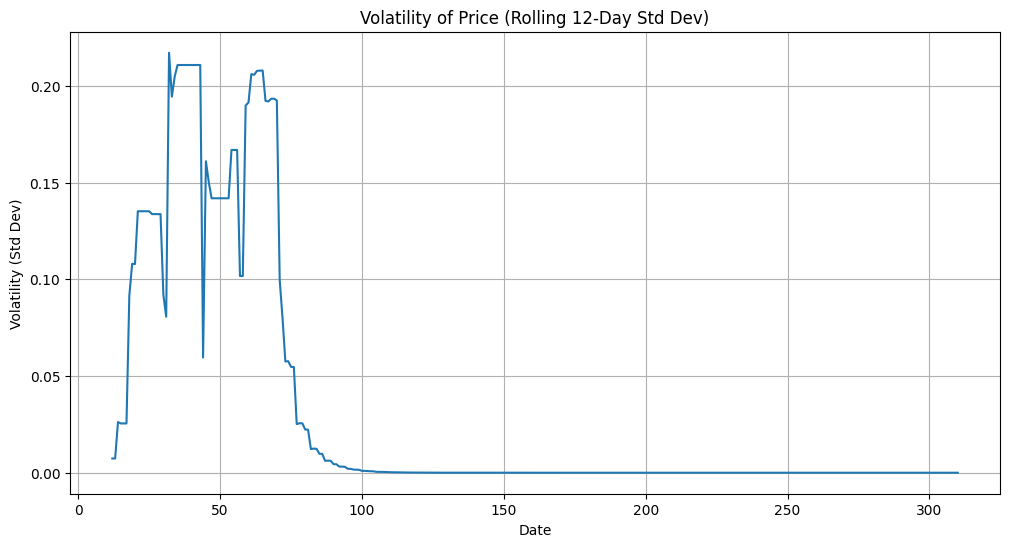

In [111]:
plot_price_volatility(df, 12)

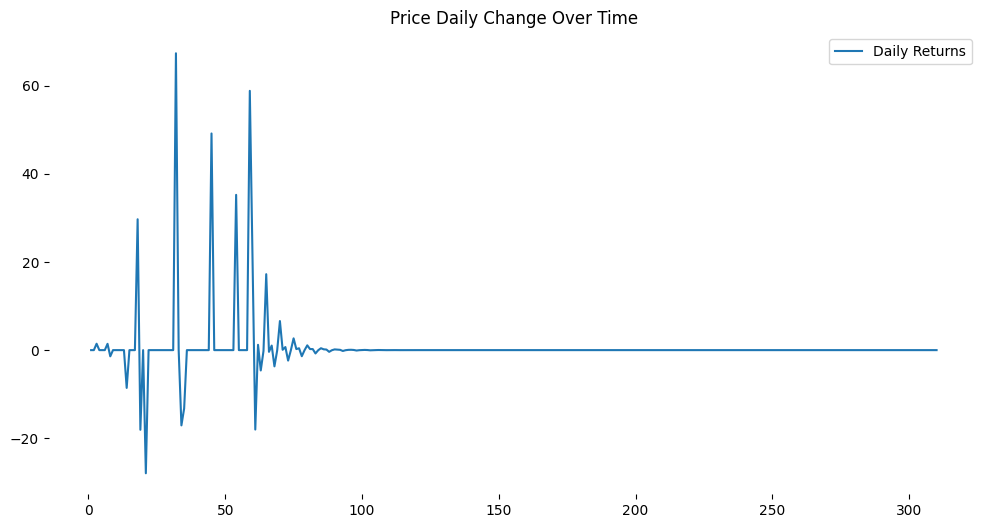

In [112]:
df['daily_change']=(df['Price'].pct_change())*100
fig,ax=plt.subplots(figsize=(12,6))
ax.spines[['top','right','left','bottom']].set_visible(False)
plt.plot(df['daily_change'], label = 'Daily Returns')
plt.legend(loc='best')
plt.title('Price Daily Change Over Time')
plt.show()

In [113]:
df.tail()

,Date,Price,Route,From,daily_change
306,27-10-2024 06:00,221.39584,NaN,iah,0.000000e+00
307,28-10-2024 06:00,221.39584,NaN,iah,0.000000e+00
308,29-10-2024 06:00,221.39584,NaN,iah,-2.220446e-14
309,30-10-2024 06:00,221.39584,NaN,iah,0.000000e+00
310,31-10-2024 06:00,221.39584,NaN,iah,2.220446e-14


# Plotting Autocorrelation Plot for Price

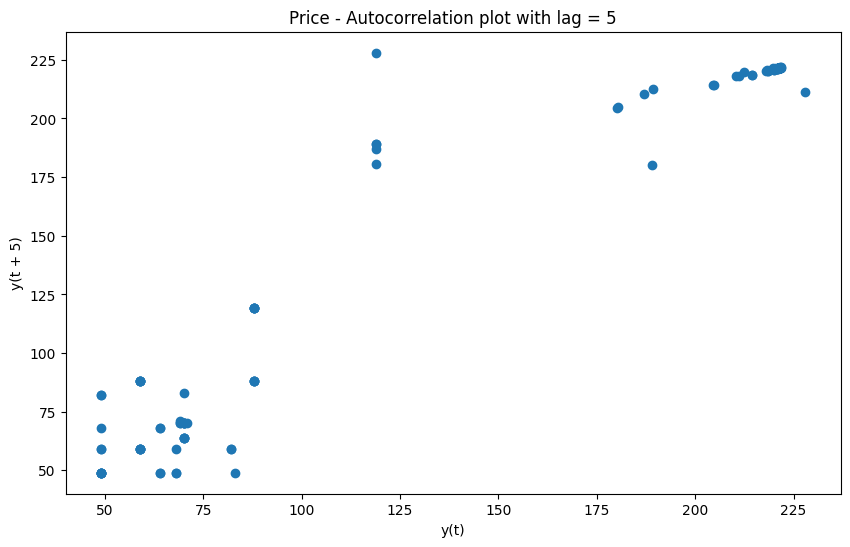

In [114]:
plt.figure()
lag_plot(df['Price'], lag=5)
plt.title('Price - Autocorrelation plot with lag = 5')
plt.show()

# Density plot for Price

<AxesSubplot: ylabel='Density'>

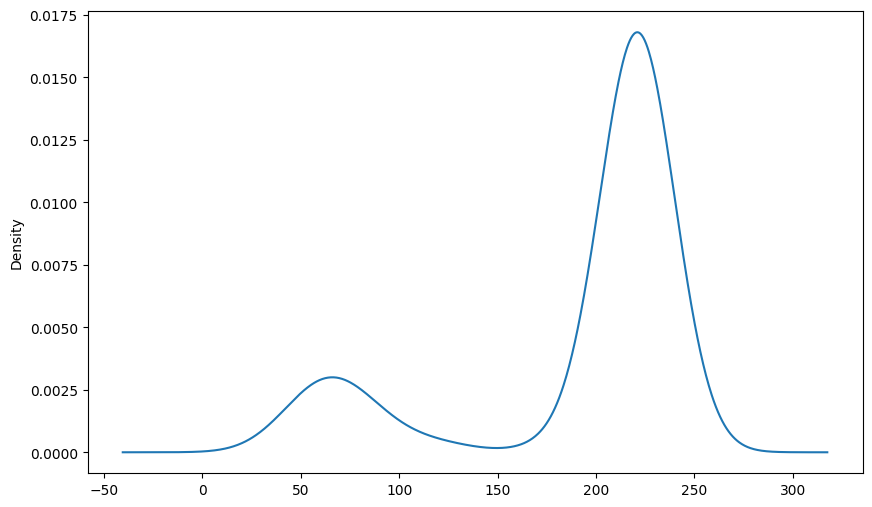

In [115]:
df_close_luv = df['Price']
df_close_luv.plot(kind='kde')

In [116]:
df.tail()

,Date,Price,Route,From,daily_change
306,27-10-2024 06:00,221.39584,NaN,iah,0.000000e+00
307,28-10-2024 06:00,221.39584,NaN,iah,0.000000e+00
308,29-10-2024 06:00,221.39584,NaN,iah,-2.220446e-14
309,30-10-2024 06:00,221.39584,NaN,iah,0.000000e+00
310,31-10-2024 06:00,221.39584,NaN,iah,2.220446e-14


# Performing Dickey Fuller Test for Price

In [117]:
df_price = df["Price"]

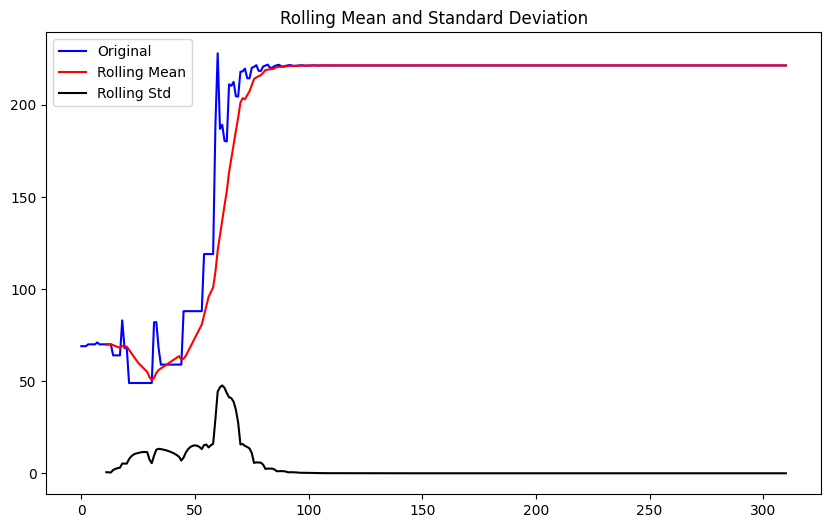

Results of dickey fuller test
Test Statistics                 -2.718176
p-value                          0.070946
No. of lags used                15.000000
Number of observations used    295.000000
critical value (1%)             -3.452713
critical value (5%)             -2.871388
critical value (10%)            -2.572017
dtype: float64


In [118]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_price)

# Separating the trend and the seasonality from a time series for Price

<Figure size 1000x600 with 0 Axes>

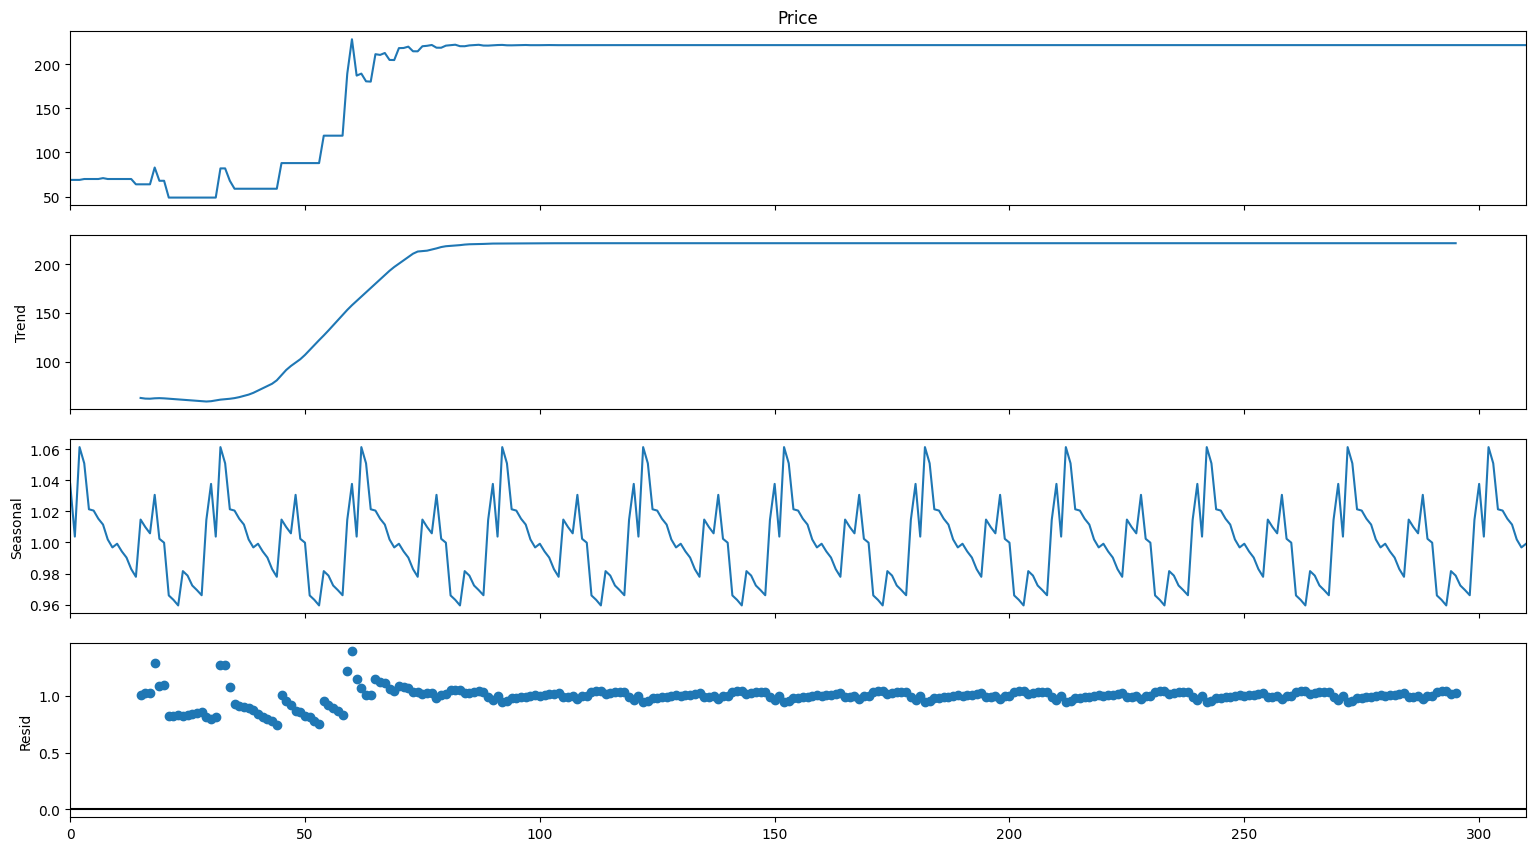

In [119]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_price, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

# Eliminating Trend for Price

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


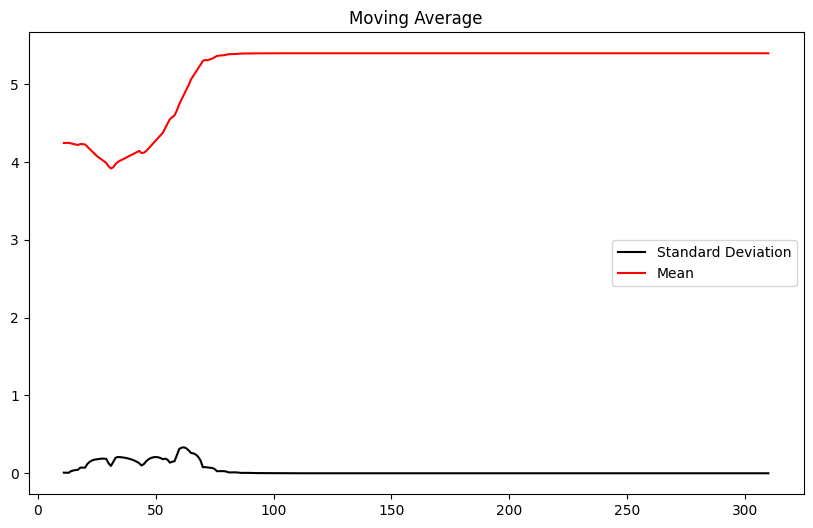

In [120]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log_price = np.log(df_price)
moving_avg_price = df_log_price.rolling(12).mean()
std_dev_price = df_log_price.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev_price, color ="black", label = "Standard Deviation")
plt.plot(moving_avg_price, color="red", label = "Mean")
plt.legend()
plt.show()

In [121]:
df_log_price.head()

0    4.234107
1    4.234107
2    4.234107
3    4.248495
4    4.248495
Name: Price, dtype: float64

# Training & Testing plot for Price

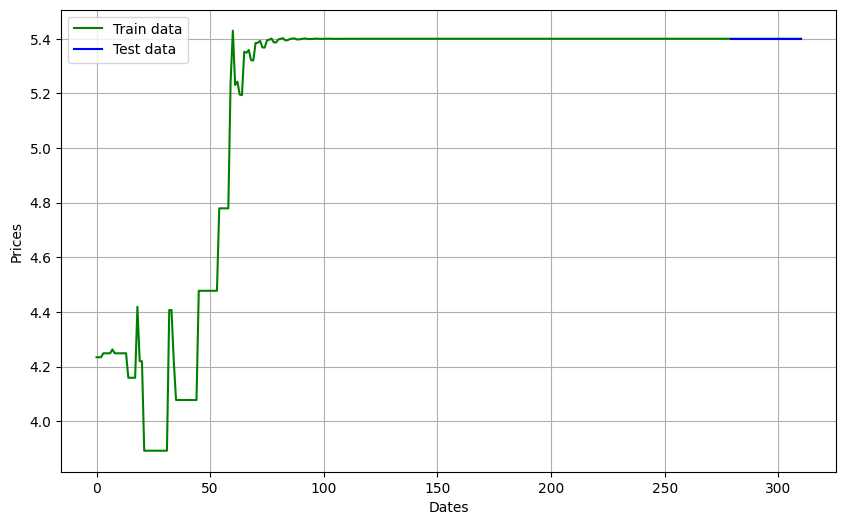

In [122]:
#split data into train and training set
train_data, test_data = df_log_price[3:int(len(df_log_price)*0.9)], df_log_price[int(len(df_log_price)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_log_price, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

# AutoArima model for Price Prediction

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-730.695, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-728.745, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-728.758, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-731.507, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-727.343, Time=0.17 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.308 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  276
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 366.753
Date:                Sun, 25 Feb 2024   AIC                           -731.507
Time:                        11:13:40   BIC                           -727.890
Sample:                             0   HQIC                          -730.055
                                - 276                                       

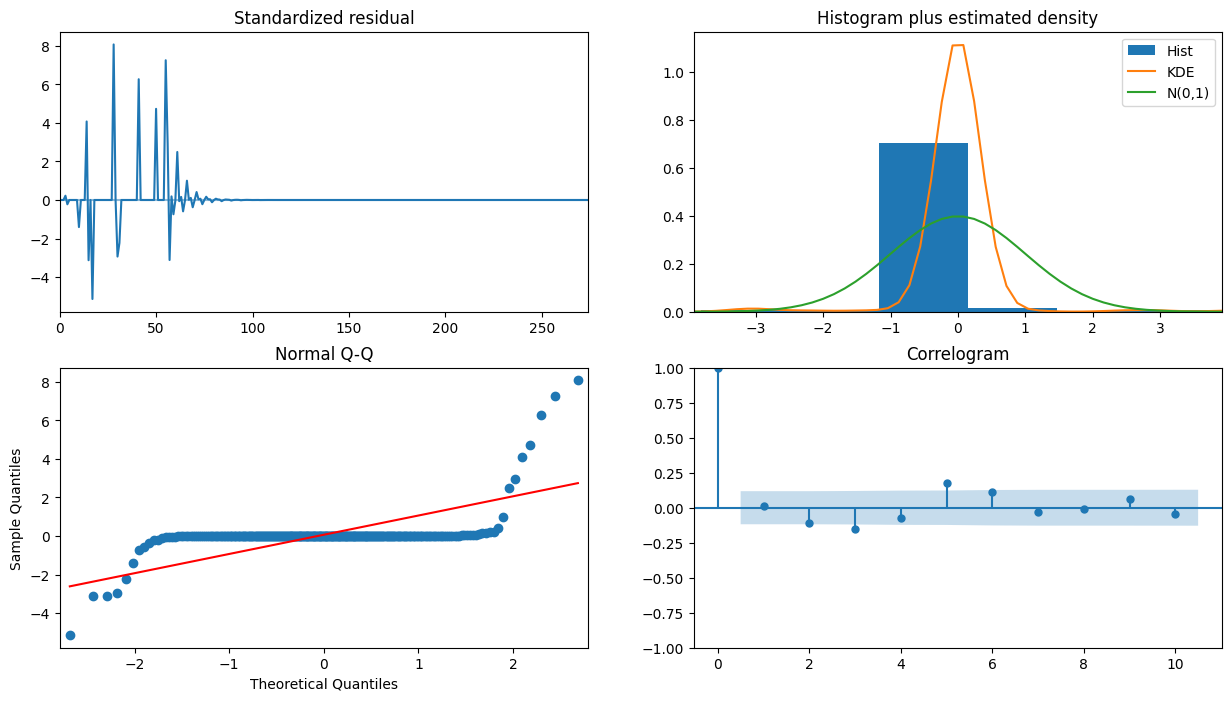

In [123]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [124]:
#Modeling
# Build Model
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Price   No. Observations:                  276
Model:                 ARIMA(1, 1, 2)   Log Likelihood                 369.350
Date:                Sun, 25 Feb 2024   AIC                           -730.700
Time:                        11:13:41   BIC                           -716.233
Sample:                             0   HQIC                          -724.894
                                - 276                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3359      0.247      1.360      0.174      -0.148       0.820
ma.L1         -0.3373      0.241     -1.400      0.162      -0.810       0.135
ma.L2         -0.1161      0.039     -2.981      0.0

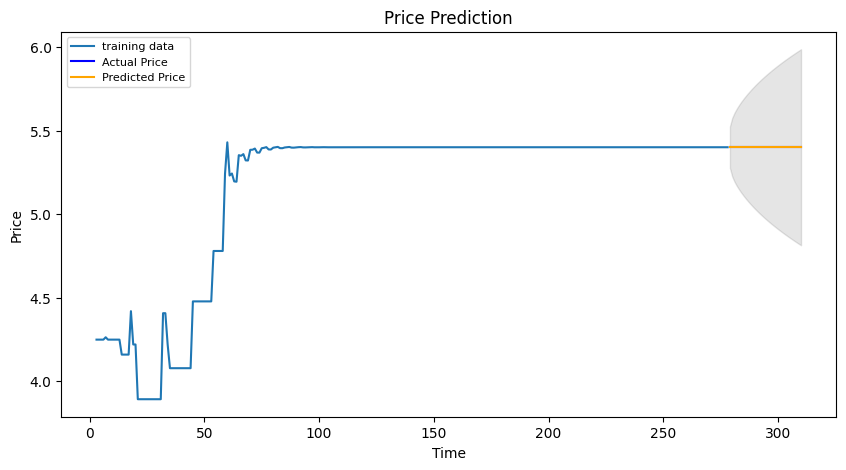

In [125]:
# Forecast
#forecast_result = fitted.get_forecast(steps=321, alpha=0.05)  # 95% conf
forecast_result = fitted.get_forecast(steps=len(test_data), alpha=0.05)  # 95% conf
fc = forecast_result.predicted_mean
conf = forecast_result.conf_int()

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)



# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Price')
plt.plot(fc_series, color = 'orange',label='Predicted Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [126]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE for Price is: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE for Price is: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE for Price is: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE for Price is: '+str(mape))

MSE for Price is: 4.1957539396442565e-29
MAE for Price is: 6.217248937900877e-15
RMSE for Price is: 6.47746396334573e-15
MAPE for Price is: 1.1513525806865817e-15


In [127]:
import statsmodels.api as sm
error = mean_squared_error(test_data, fc)
error

4.1957539396442565e-29

In [128]:
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) +       np.abs(y_true))))

In [129]:
smape = smape_kun(test_data, fc)
print('Symmetric mean absolute error for Price is: %.3f' % smape)

Symmetric mean absolute error for Price is: 0.000


# Model 2

In [131]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [132]:
df_aus = pd.read_csv("flight_data_and_price_history_AUS_to_SAT.csv")
df_aus.head()

,Date,Price,From
0,26-12-2023 06:00,107,AUS
1,27-12-2023 06:00,107,AUS
2,28-12-2023 06:00,107,AUS
3,29-12-2023 06:00,107,AUS
4,30-12-2023 06:00,107,AUS


In [133]:
df_price_aus = df_aus['Price']

In [134]:
df_price_aus.tail()

56    116
57    116
58    141
59    226
60    195
Name: Price, dtype: int64

# Following codes below represent dividing the data into train and test

In [137]:
len(df_aus)

61

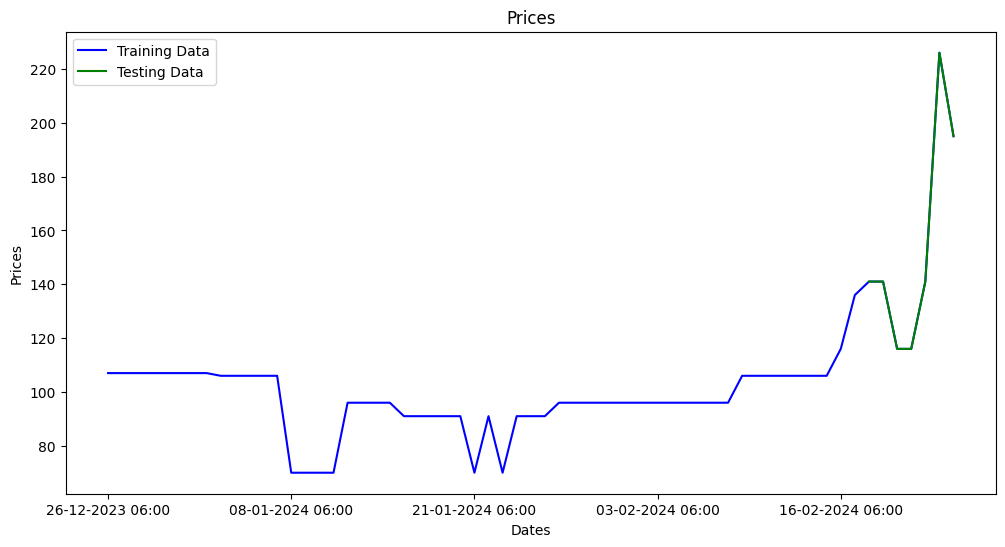

In [138]:
train_data_aus, test_data_aus = df_aus[0:int(len(df_aus)*0.9)], df_aus[int(len(df_aus)*0.9):]
plt.figure(figsize=(12,6))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_aus['Price'], 'blue', label='Training Data')
plt.plot(test_data_aus['Price'], 'green', label='Testing Data')
plt.xticks(np.arange(0,61, 13), df_aus['Date'][0:61:13])
plt.legend()

# Defining the function Symmetric Mean Absolute Percentage Error

# Taking only the Close column values for Training and Testing

In [139]:
train_ar_aus = train_data_aus['Price'].values
test_ar_aus = test_data_aus['Price'].values

# New ARIMA model with different p,d,q values and calculating differnet Error values and predicting the new model 

In [140]:
import statsmodels.api as sm

history_aus = [x for x in train_ar_aus]
print(type(history_aus))
predictions_aus = list()
for t in range(len(test_ar_aus)):
    model_aus = sm.tsa.arima.ARIMA(history_aus, order=(5,1,0))
    model_fit_aus = model_aus.fit()
    output_aus = model_fit_aus.forecast()
    yhat = output_aus[0]
    predictions_aus.append(yhat)
    obs = test_ar_aus[t]
    history_aus.append(obs)
error = mean_squared_error(test_ar_aus, predictions_aus)
print('Testing Mean Squared Error: %.3f' % error)
#error2 = smape_kun(test_ar_aus, predictions_aus)
#print('Symmetric mean absolute error: %.3f' % error2)

mae_2 = mean_absolute_error(test_ar_aus, predictions_aus)
print('MAE: '+str(mae_2))
rmse_2 = math.sqrt(mean_squared_error(test_ar_aus, predictions_aus))
print('RMSE: '+str(rmse_2))
mape_2 = np.mean(np.abs(predictions_aus - test_ar_aus)/np.abs(test_ar_aus))
print('MAPE: '+str(mape_2))

<class 'list'>
Testing Mean Squared Error: 1786.197
MAE: 30.912532558955665
RMSE: 42.26342143282102
MAPE: 0.17560378581443334


# Plotting the Predictions and Actual Values

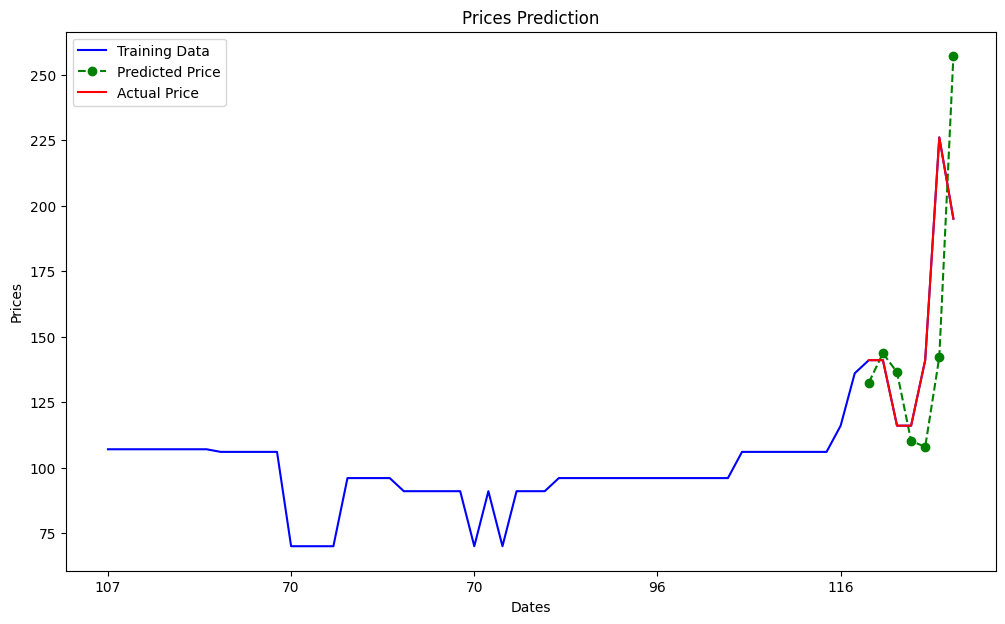

In [142]:
plt.figure(figsize=(12,7))
plt.plot(df_aus['Price'], 'green', color='blue', label='Training Data')
plt.plot(test_data_aus.index, predictions_aus, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_aus.index, test_data_aus['Price'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,61, 13), df_aus['Price'][0:61:13])
plt.legend()

<class 'list'>
Testing Mean Squared Error: 279.672
MAE: 12.792283339141182
RMSE: 16.723396746165296
MAPE: 0.11091399091898038


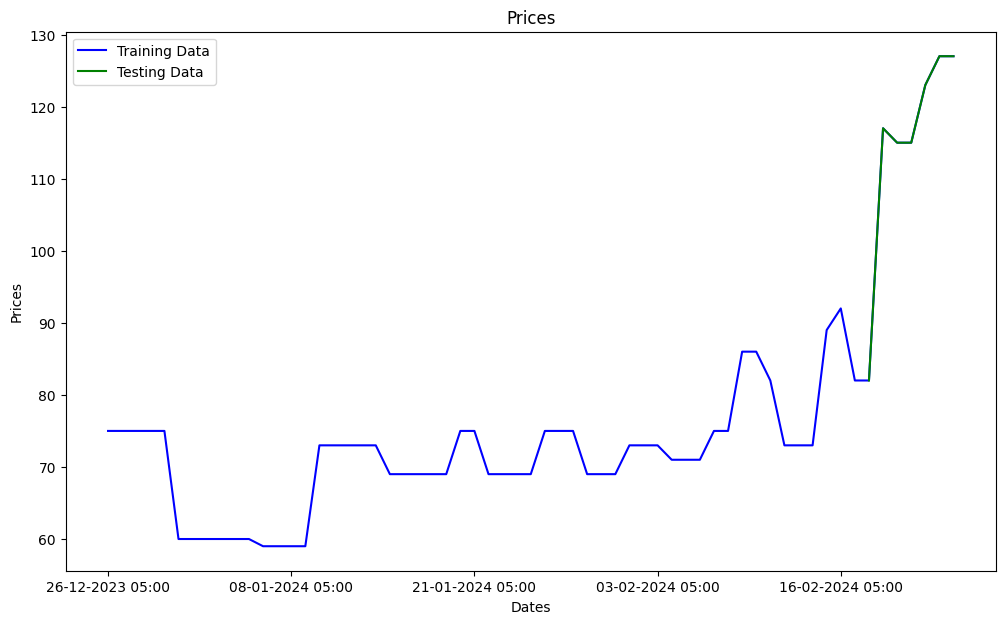

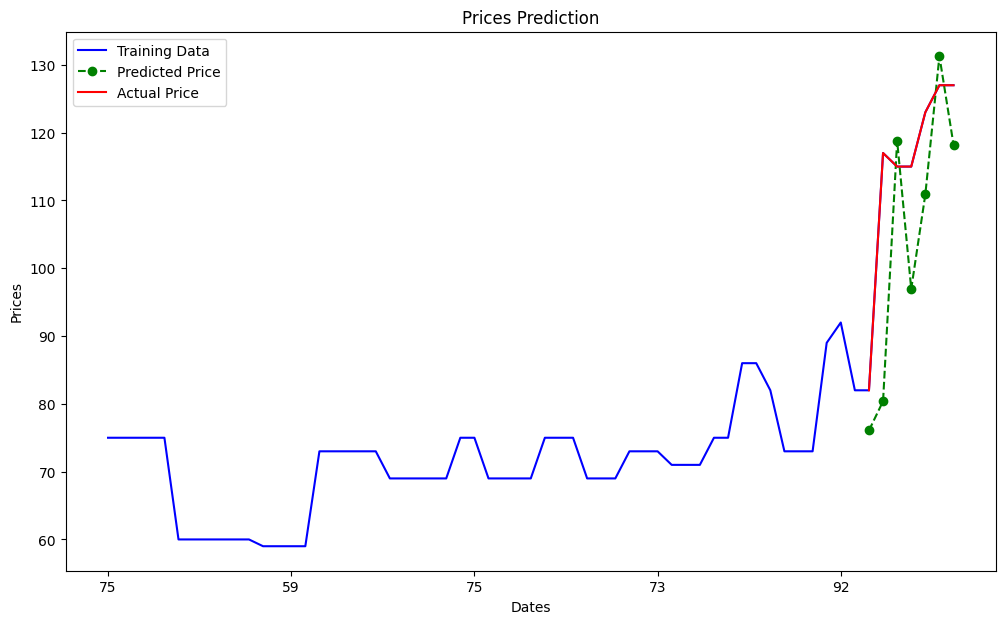

In [143]:
df_bos = pd.read_csv("flight_data_and_price_history_bos_to_SAT.csv")
df_bos.head()
df_price_bos = df_bos['Price']
df_price_bos.tail()
train_data_bos, test_data_bos = df_bos[0:int(len(df_bos)*0.9)], df_bos[int(len(df_bos)*0.9):]
plt.figure(figsize=(12,7))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_bos['Price'], 'blue', label='Training Data')
plt.plot(test_data_bos['Price'], 'green', label='Testing Data')
plt.xticks(np.arange(0,61, 13), df_bos['Date'][0:61:13])
plt.legend()
train_ar_bos = train_data_bos['Price'].values
test_ar_bos = test_data_bos['Price'].values
import statsmodels.api as sm

history_bos = [x for x in train_ar_bos]
print(type(history_bos))
predictions_bos = list()
for t in range(len(test_ar_bos)):
    model_bos = sm.tsa.arima.ARIMA(history_bos, order=(5,1,0))
    model_fit_bos = model_bos.fit()
    output_bos = model_fit_bos.forecast()
    yhat = output_bos[0]
    predictions_bos.append(yhat)
    obs = test_ar_bos[t]
    history_bos.append(obs)
error = mean_squared_error(test_ar_bos, predictions_bos)
print('Testing Mean Squared Error: %.3f' % error)
#error2 = smape_kun(test_ar_bos, predictions_bos)
#print('Symmetric mean absolute error: %.3f' % error2)

mae_2 = mean_absolute_error(test_ar_bos, predictions_bos)
print('MAE: '+str(mae_2))
rmse_2 = math.sqrt(mean_squared_error(test_ar_bos, predictions_bos))
print('RMSE: '+str(rmse_2))
mape_2 = np.mean(np.abs(predictions_bos - test_ar_bos)/np.abs(test_ar_bos))
print('MAPE: '+str(mape_2))
plt.figure(figsize=(12,7))
plt.plot(df_bos['Price'], 'green', color='blue', label='Training Data')
plt.plot(test_data_bos.index, predictions_bos, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_bos.index, test_data_bos['Price'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,61, 13), df_bos['Price'][0:61:13])
plt.legend()

<class 'list'>
Testing Mean Squared Error: 568.691
MAE: 15.772124295988439
RMSE: 23.847253072657182
MAPE: 0.17107981229723687


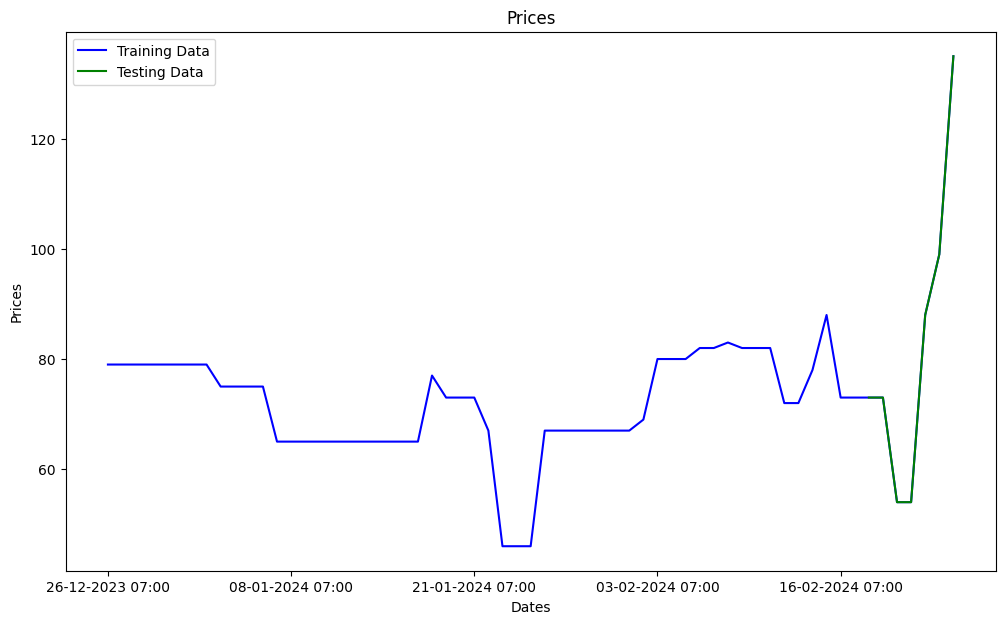

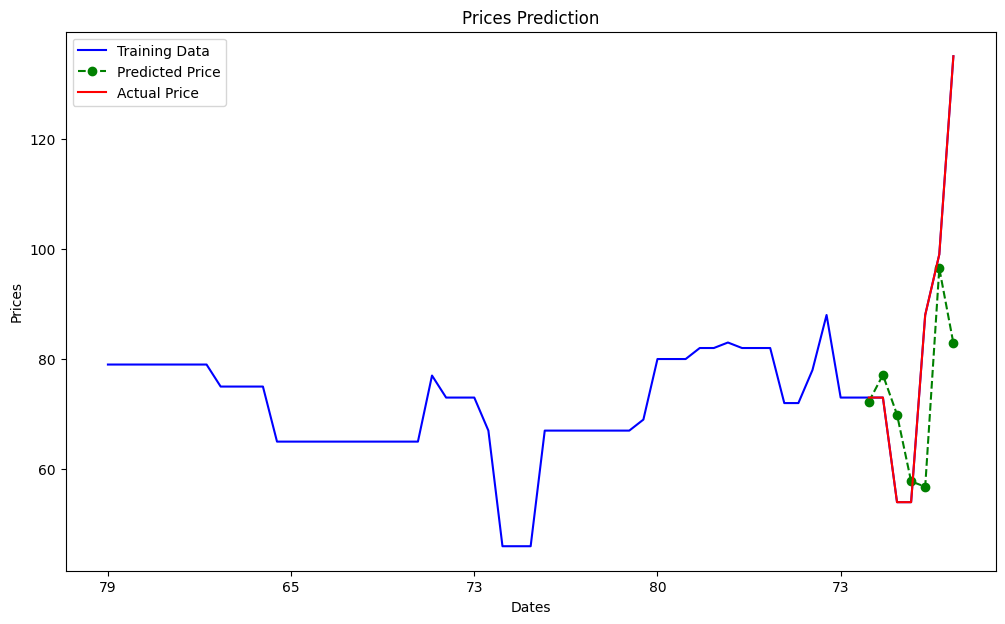

In [144]:
df_slc = pd.read_csv("flight_data_and_price_history_slc_to_SAT.csv")
df_slc.head()
df_price_slc = df_slc['Price']
df_price_slc.tail()
train_data_slc, test_data_slc = df_slc[0:int(len(df_slc)*0.9)], df_slc[int(len(df_slc)*0.9):]
plt.figure(figsize=(12,7))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_slc['Price'], 'blue', label='Training Data')
plt.plot(test_data_slc['Price'], 'green', label='Testing Data')
plt.xticks(np.arange(0,61, 13), df_slc['Date'][0:61:13])
plt.legend()
train_ar_slc = train_data_slc['Price'].values
test_ar_slc = test_data_slc['Price'].values
import statsmodels.api as sm

history_slc = [x for x in train_ar_slc]
print(type(history_slc))
predictions_slc = list()
for t in range(len(test_ar_slc)):
    model_slc = sm.tsa.arima.ARIMA(history_slc, order=(5,1,0))
    model_fit_slc = model_slc.fit()
    output_slc = model_fit_slc.forecast()
    yhat = output_slc[0]
    predictions_slc.append(yhat)
    obs = test_ar_slc[t]
    history_slc.append(obs)
error = mean_squared_error(test_ar_slc, predictions_slc)
print('Testing Mean Squared Error: %.3f' % error)
#error2 = smape_kun(test_ar_slc, predictions_slc)
#print('Symmetric mean absolute error: %.3f' % error2)

mae_2 = mean_absolute_error(test_ar_slc, predictions_slc)
print('MAE: '+str(mae_2))
rmse_2 = math.sqrt(mean_squared_error(test_ar_slc, predictions_slc))
print('RMSE: '+str(rmse_2))
mape_2 = np.mean(np.abs(predictions_slc - test_ar_slc)/np.abs(test_ar_slc))
print('MAPE: '+str(mape_2))
plt.figure(figsize=(12,7))
plt.plot(df_slc['Price'], 'green', color='blue', label='Training Data')
plt.plot(test_data_slc.index, predictions_slc, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_slc.index, test_data_slc['Price'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,61, 13), df_slc['Price'][0:61:13])
plt.legend()

<class 'list'>
Testing Mean Squared Error: 575.213
MAE: 14.007264775038928
RMSE: 23.98360016010182
MAPE: 0.1290890322982607


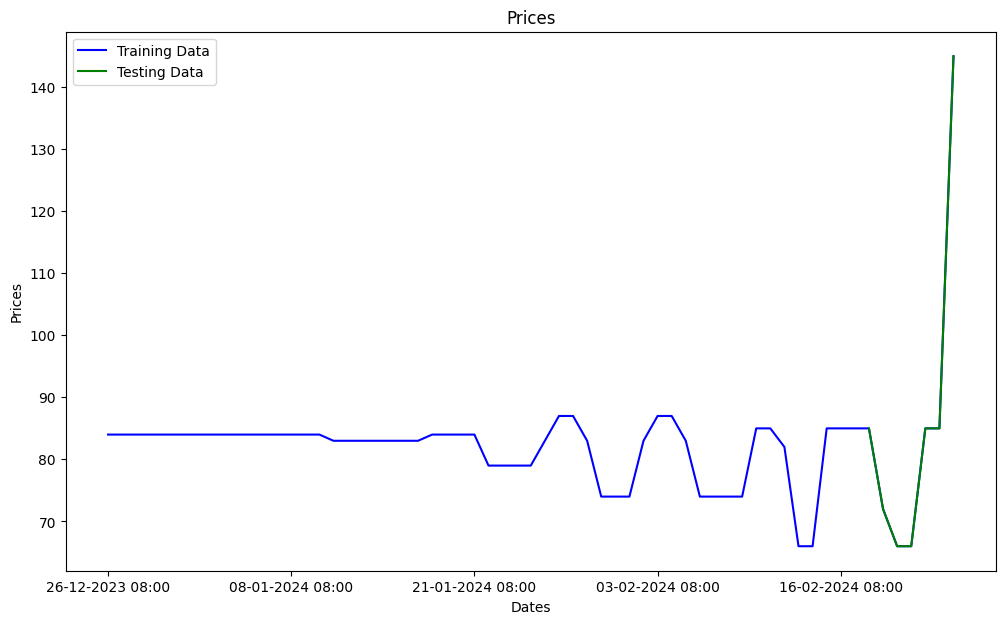

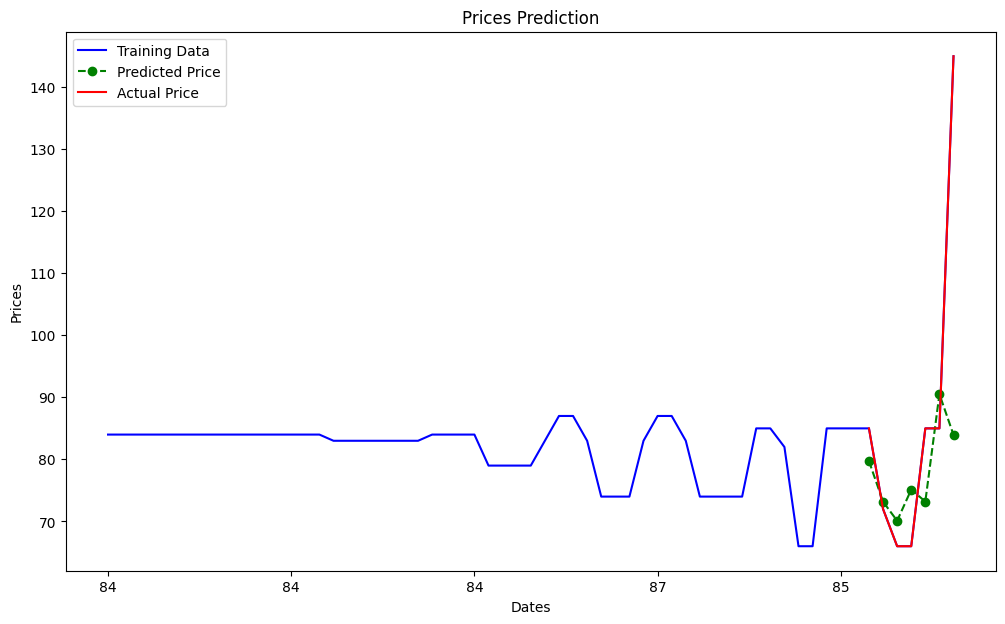

In [145]:
df_sfo = pd.read_csv("flight_data_and_price_history_sfo_to_SAT.csv")
df_sfo.head()
df_price_sfo = df_sfo['Price']
df_price_sfo.tail()
train_data_sfo, test_data_sfo = df_sfo[0:int(len(df_sfo)*0.9)], df_sfo[int(len(df_sfo)*0.9):]
plt.figure(figsize=(12,7))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_sfo['Price'], 'blue', label='Training Data')
plt.plot(test_data_sfo['Price'], 'green', label='Testing Data')
plt.xticks(np.arange(0,61, 13), df_sfo['Date'][0:61:13])
plt.legend()
train_ar_sfo = train_data_sfo['Price'].values
test_ar_sfo = test_data_sfo['Price'].values
import statsmodels.api as sm

history_sfo = [x for x in train_ar_sfo]
print(type(history_sfo))
predictions_sfo = list()
for t in range(len(test_ar_sfo)):
    model_sfo = sm.tsa.arima.ARIMA(history_sfo, order=(5,1,0))
    model_fit_sfo = model_sfo.fit()
    output_sfo = model_fit_sfo.forecast()
    yhat = output_sfo[0]
    predictions_sfo.append(yhat)
    obs = test_ar_sfo[t]
    history_sfo.append(obs)
error = mean_squared_error(test_ar_sfo, predictions_sfo)
print('Testing Mean Squared Error: %.3f' % error)
#error2 = smape_kun(test_ar_sfo, predictions_sfo)
#print('Symmetric mean absolute error: %.3f' % error2)

mae_2 = mean_absolute_error(test_ar_sfo, predictions_sfo)
print('MAE: '+str(mae_2))
rmse_2 = math.sqrt(mean_squared_error(test_ar_sfo, predictions_sfo))
print('RMSE: '+str(rmse_2))
mape_2 = np.mean(np.abs(predictions_sfo - test_ar_sfo)/np.abs(test_ar_sfo))
print('MAPE: '+str(mape_2))
plt.figure(figsize=(12,7))
plt.plot(df_sfo['Price'], 'green', color='blue', label='Training Data')
plt.plot(test_data_sfo.index, predictions_sfo, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_sfo.index, test_data_sfo['Price'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,61, 13), df_sfo['Price'][0:61:13])
plt.legend()

<class 'list'>
Testing Mean Squared Error: 1635.572
MAE: 15.292467645753206
RMSE: 40.442202559041355
MAPE: 0.08501314670198999


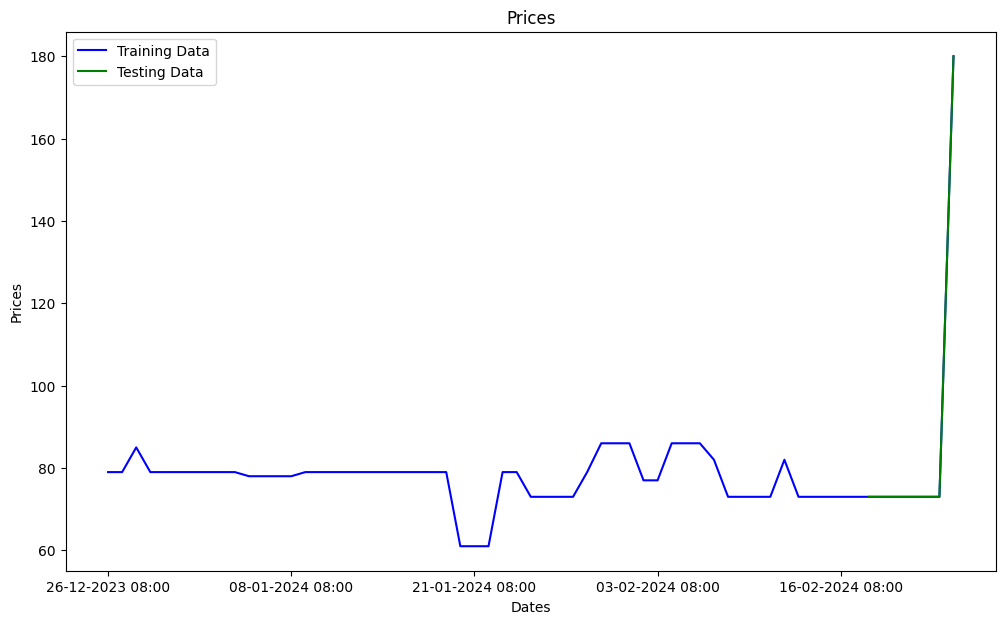

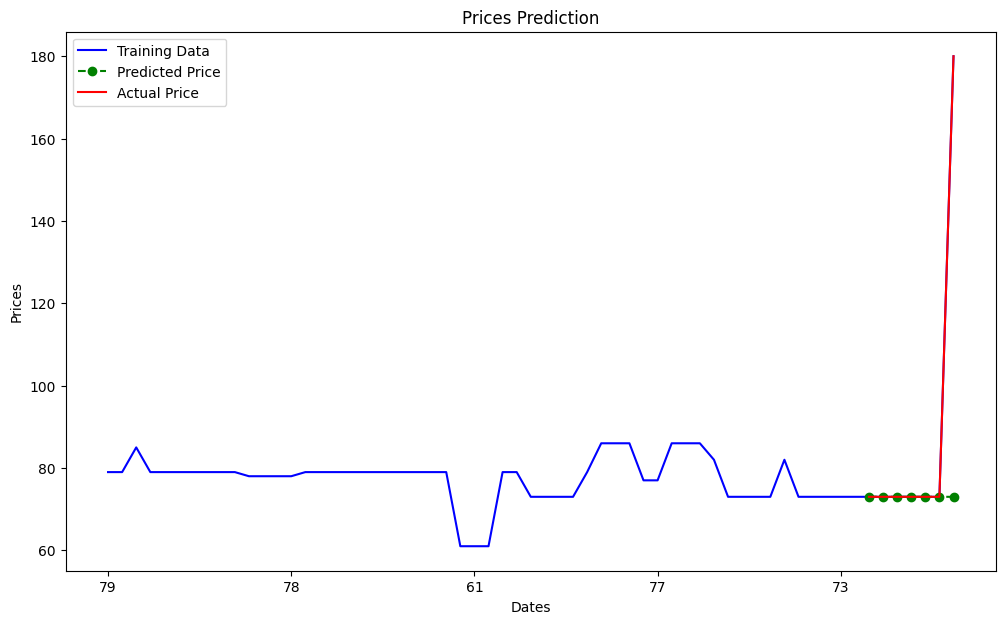

In [146]:
df_sea = pd.read_csv("flight_data_and_price_history_sea_to_SAT.csv")
df_sea.head()
df_price_sea = df_sea['Price']
df_price_sea.tail()
train_data_sea, test_data_sea = df_sea[0:int(len(df_sea)*0.9)], df_sea[int(len(df_sea)*0.9):]
plt.figure(figsize=(12,7))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_sea['Price'], 'blue', label='Training Data')
plt.plot(test_data_sea['Price'], 'green', label='Testing Data')
plt.xticks(np.arange(0,61, 13), df_sea['Date'][0:61:13])
plt.legend()
train_ar_sea = train_data_sea['Price'].values
test_ar_sea = test_data_sea['Price'].values
import statsmodels.api as sm

history_sea = [x for x in train_ar_sea]
print(type(history_sea))
predictions_sea = list()
for t in range(len(test_ar_sea)):
    model_sea = sm.tsa.arima.ARIMA(history_sea, order=(5,1,0))
    model_fit_sea = model_sea.fit()
    output_sea = model_fit_sea.forecast()
    yhat = output_sea[0]
    predictions_sea.append(yhat)
    obs = test_ar_sea[t]
    history_sea.append(obs)
error = mean_squared_error(test_ar_sea, predictions_sea)
print('Testing Mean Squared Error: %.3f' % error)
#error2 = smape_kun(test_ar_sea, predictions_sea)
#print('Symmetric mean absolute error: %.3f' % error2)

mae_2 = mean_absolute_error(test_ar_sea, predictions_sea)
print('MAE: '+str(mae_2))
rmse_2 = math.sqrt(mean_squared_error(test_ar_sea, predictions_sea))
print('RMSE: '+str(rmse_2))
mape_2 = np.mean(np.abs(predictions_sea - test_ar_sea)/np.abs(test_ar_sea))
print('MAPE: '+str(mape_2))
plt.figure(figsize=(12,7))
plt.plot(df_sea['Price'], 'green', color='blue', label='Training Data')
plt.plot(test_data_sea.index, predictions_sea, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_sea.index, test_data_sea['Price'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,61, 13), df_sea['Price'][0:61:13])
plt.legend()

<class 'list'>
Testing Mean Squared Error: 13.007
MAE: 3.222012145683674
RMSE: 3.6065484939502124
MAPE: 0.025066350520234298


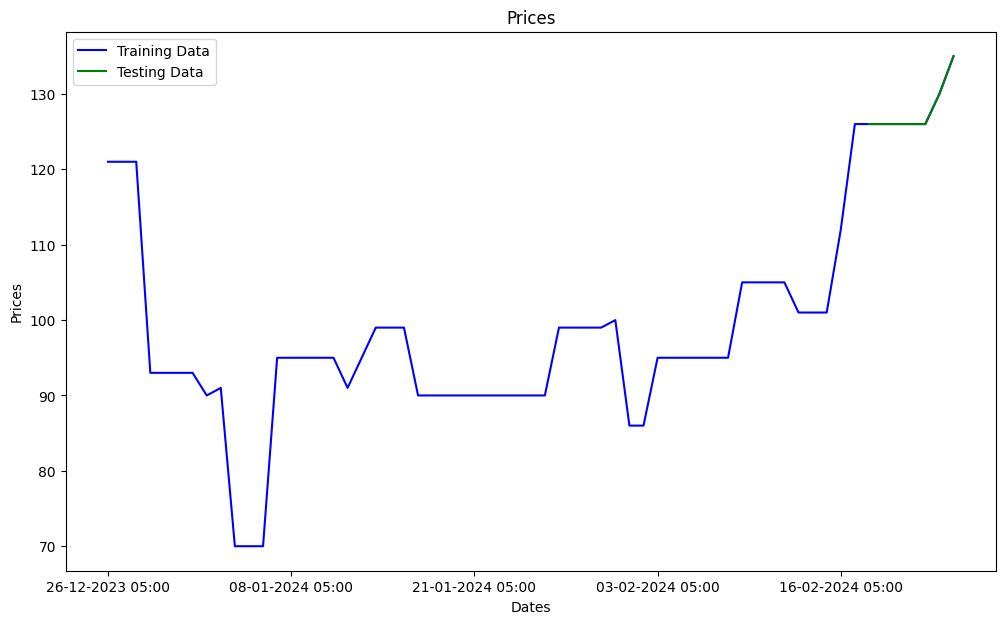

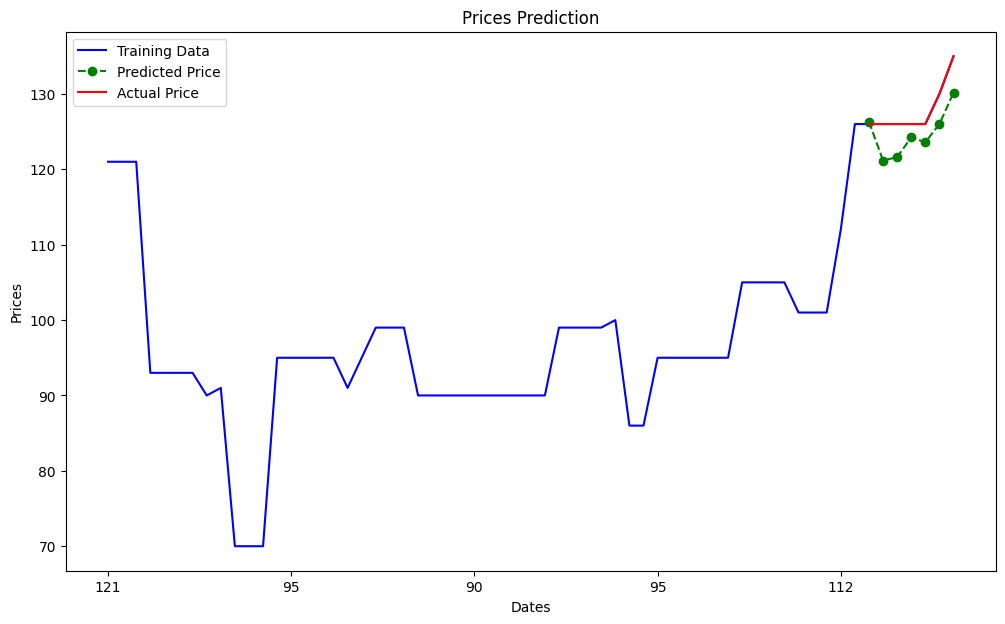

In [147]:
df_mia = pd.read_csv("flight_data_and_price_history_mia_to_SAT.csv")
df_mia.head()
df_price_mia = df_mia['Price']
df_price_mia.tail()
train_data_mia, test_data_mia = df_mia[0:int(len(df_mia)*0.9)], df_mia[int(len(df_mia)*0.9):]
plt.figure(figsize=(12,7))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_mia['Price'], 'blue', label='Training Data')
plt.plot(test_data_mia['Price'], 'green', label='Testing Data')
plt.xticks(np.arange(0,61, 13), df_mia['Date'][0:61:13])
plt.legend()
train_ar_mia = train_data_mia['Price'].values
test_ar_mia = test_data_mia['Price'].values
import statsmodels.api as sm

history_mia = [x for x in train_ar_mia]
print(type(history_mia))
predictions_mia = list()
for t in range(len(test_ar_mia)):
    model_mia = sm.tsa.arima.ARIMA(history_mia, order=(5,1,0))
    model_fit_mia = model_mia.fit()
    output_mia = model_fit_mia.forecast()
    yhat = output_mia[0]
    predictions_mia.append(yhat)
    obs = test_ar_mia[t]
    history_mia.append(obs)
error = mean_squared_error(test_ar_mia, predictions_mia)
print('Testing Mean Squared Error: %.3f' % error)
#error2 = smape_kun(test_ar_mia, predictions_mia)
#print('Symmetric mean absolute error: %.3f' % error2)

mae_2 = mean_absolute_error(test_ar_mia, predictions_mia)
print('MAE: '+str(mae_2))
rmse_2 = math.sqrt(mean_squared_error(test_ar_mia, predictions_mia))
print('RMSE: '+str(rmse_2))
mape_2 = np.mean(np.abs(predictions_mia - test_ar_mia)/np.abs(test_ar_mia))
print('MAPE: '+str(mape_2))
plt.figure(figsize=(12,7))
plt.plot(df_mia['Price'], 'green', color='blue', label='Training Data')
plt.plot(test_data_mia.index, predictions_mia, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_mia.index, test_data_mia['Price'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,61, 13), df_mia['Price'][0:61:13])
plt.legend()

<class 'list'>
Testing Mean Squared Error: 1235.615
MAE: 13.380035816536191
RMSE: 35.1513194235251
MAPE: 0.051864270981372244


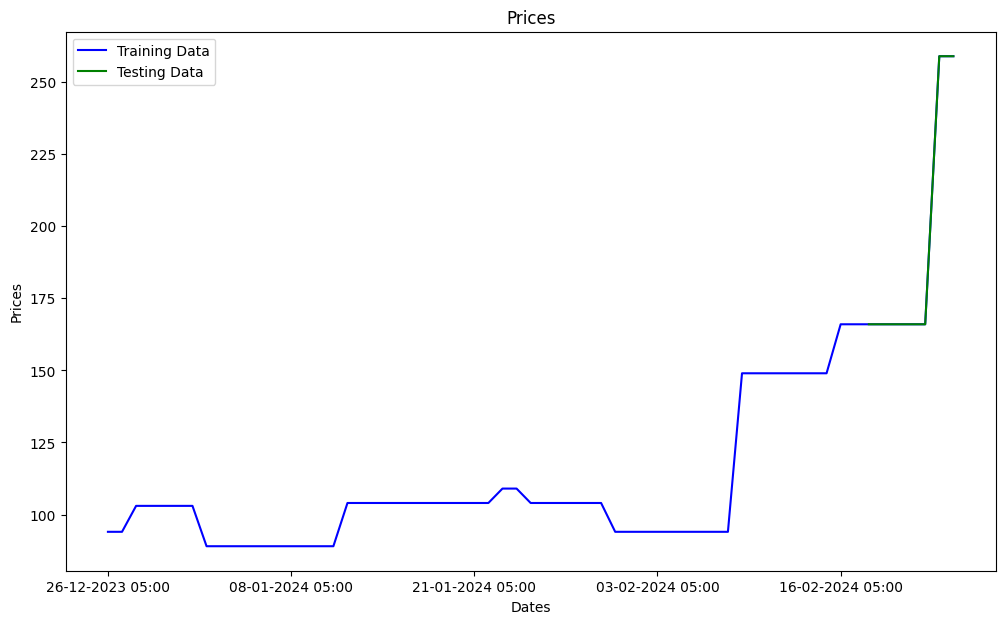

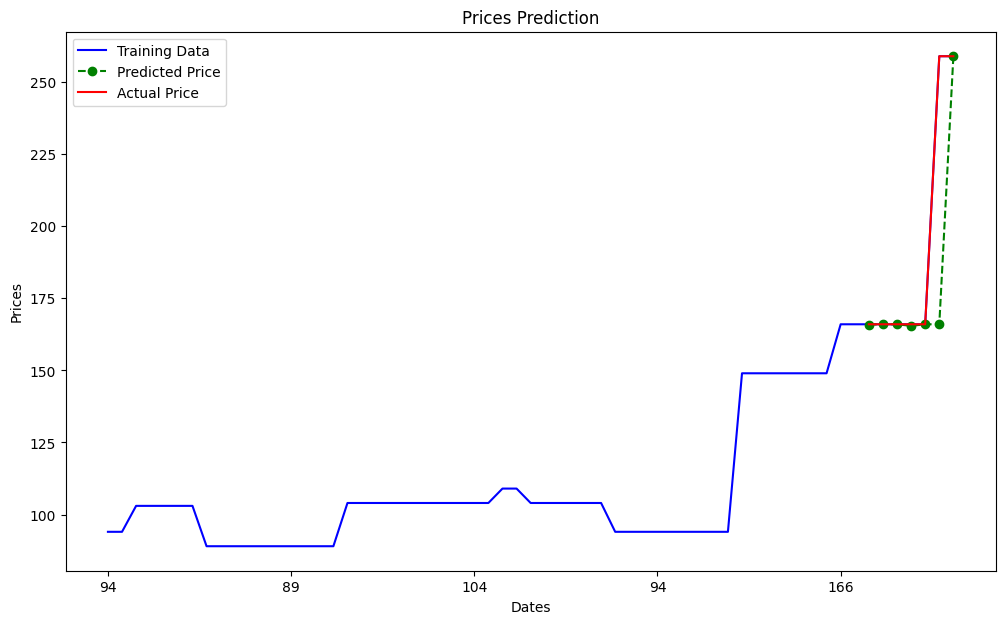

In [148]:
df_jfk = pd.read_csv("flight_data_and_price_history_jfk_to_SAT.csv")
df_jfk.head()
df_price_jfk = df_jfk['Price']
df_price_jfk.tail()
train_data_jfk, test_data_jfk = df_jfk[0:int(len(df_jfk)*0.9)], df_jfk[int(len(df_jfk)*0.9):]
plt.figure(figsize=(12,7))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_jfk['Price'], 'blue', label='Training Data')
plt.plot(test_data_jfk['Price'], 'green', label='Testing Data')
plt.xticks(np.arange(0,61, 13), df_jfk['Date'][0:61:13])
plt.legend()
train_ar_jfk = train_data_jfk['Price'].values
test_ar_jfk = test_data_jfk['Price'].values
import statsmodels.api as sm

history_jfk = [x for x in train_ar_jfk]
print(type(history_jfk))
predictions_jfk = list()
for t in range(len(test_ar_jfk)):
    model_jfk = sm.tsa.arima.ARIMA(history_jfk, order=(5,1,0))
    model_fit_jfk = model_jfk.fit()
    output_jfk = model_fit_jfk.forecast()
    yhat = output_jfk[0]
    predictions_jfk.append(yhat)
    obs = test_ar_jfk[t]
    history_jfk.append(obs)
error = mean_squared_error(test_ar_jfk, predictions_jfk)
print('Testing Mean Squared Error: %.3f' % error)
#error2 = smape_kun(test_ar_jfk, predictions_jfk)
#print('Symmetric mean absolute error: %.3f' % error2)

mae_2 = mean_absolute_error(test_ar_jfk, predictions_jfk)
print('MAE: '+str(mae_2))
rmse_2 = math.sqrt(mean_squared_error(test_ar_jfk, predictions_jfk))
print('RMSE: '+str(rmse_2))
mape_2 = np.mean(np.abs(predictions_jfk - test_ar_jfk)/np.abs(test_ar_jfk))
print('MAPE: '+str(mape_2))
plt.figure(figsize=(12,7))
plt.plot(df_jfk['Price'], 'green', color='blue', label='Training Data')
plt.plot(test_data_jfk.index, predictions_jfk, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_jfk.index, test_data_jfk['Price'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,61, 13), df_jfk['Price'][0:61:13])
plt.legend()

<class 'list'>
Testing Mean Squared Error: 1235.615
MAE: 13.380035816536191
RMSE: 35.1513194235251
MAPE: 0.051864270981372244


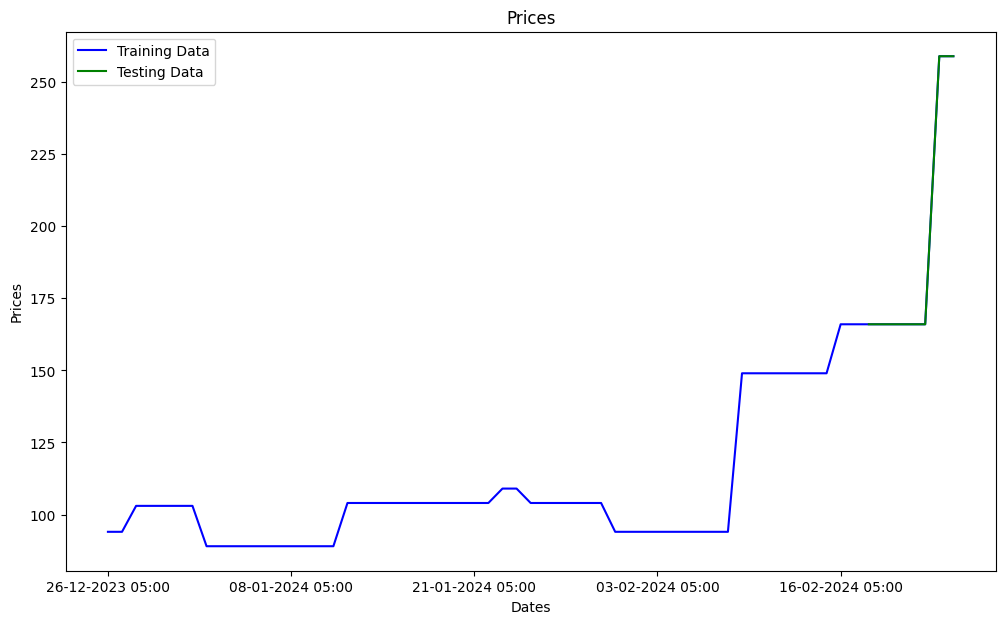

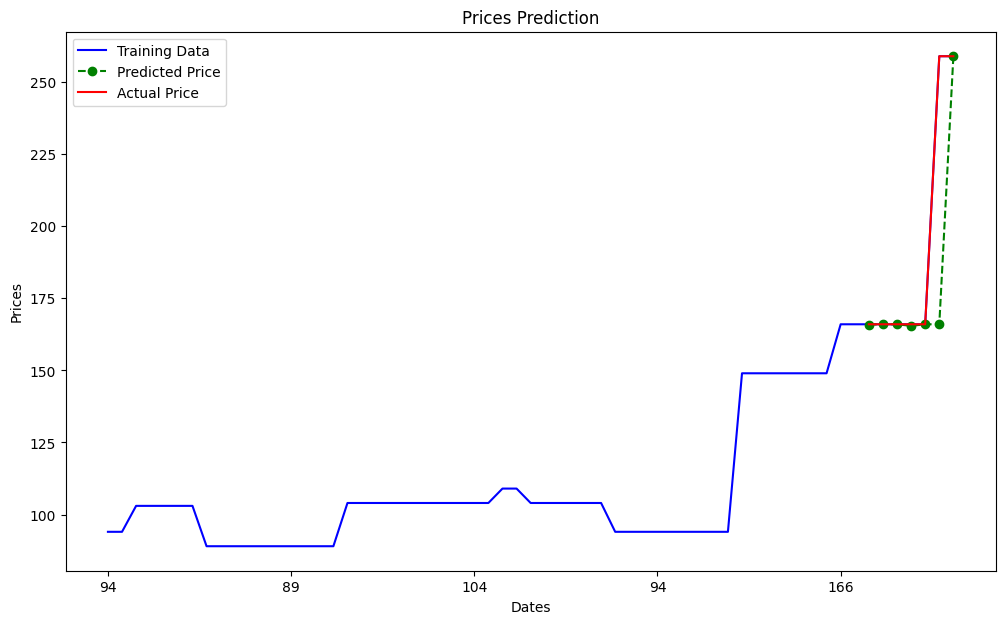

In [149]:
df_jfk = pd.read_csv("flight_data_and_price_history_jfk_to_SAT.csv")
df_jfk.head()
df_price_jfk = df_jfk['Price']
df_price_jfk.tail()
train_data_jfk, test_data_jfk = df_jfk[0:int(len(df_jfk)*0.9)], df_jfk[int(len(df_jfk)*0.9):]
plt.figure(figsize=(12,7))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_jfk['Price'], 'blue', label='Training Data')
plt.plot(test_data_jfk['Price'], 'green', label='Testing Data')
plt.xticks(np.arange(0,61, 13), df_jfk['Date'][0:61:13])
plt.legend()
train_ar_jfk = train_data_jfk['Price'].values
test_ar_jfk = test_data_jfk['Price'].values
import statsmodels.api as sm

history_jfk = [x for x in train_ar_jfk]
print(type(history_jfk))
predictions_jfk = list()
for t in range(len(test_ar_jfk)):
    model_jfk = sm.tsa.arima.ARIMA(history_jfk, order=(5,1,0))
    model_fit_jfk = model_jfk.fit()
    output_jfk = model_fit_jfk.forecast()
    yhat = output_jfk[0]
    predictions_jfk.append(yhat)
    obs = test_ar_jfk[t]
    history_jfk.append(obs)
error = mean_squared_error(test_ar_jfk, predictions_jfk)
print('Testing Mean Squared Error: %.3f' % error)
#error2 = smape_kun(test_ar_jfk, predictions_jfk)
#print('Symmetric mean absolute error: %.3f' % error2)

mae_2 = mean_absolute_error(test_ar_jfk, predictions_jfk)
print('MAE: '+str(mae_2))
rmse_2 = math.sqrt(mean_squared_error(test_ar_jfk, predictions_jfk))
print('RMSE: '+str(rmse_2))
mape_2 = np.mean(np.abs(predictions_jfk - test_ar_jfk)/np.abs(test_ar_jfk))
print('MAPE: '+str(mape_2))
plt.figure(figsize=(12,7))
plt.plot(df_jfk['Price'], 'green', color='blue', label='Training Data')
plt.plot(test_data_jfk.index, predictions_jfk, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_jfk.index, test_data_jfk['Price'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,61, 13), df_jfk['Price'][0:61:13])
plt.legend()

<class 'list'>
Testing Mean Squared Error: 174.712
MAE: 12.107760714285787
RMSE: 13.217870257602549
MAPE: 0.14298473388222493


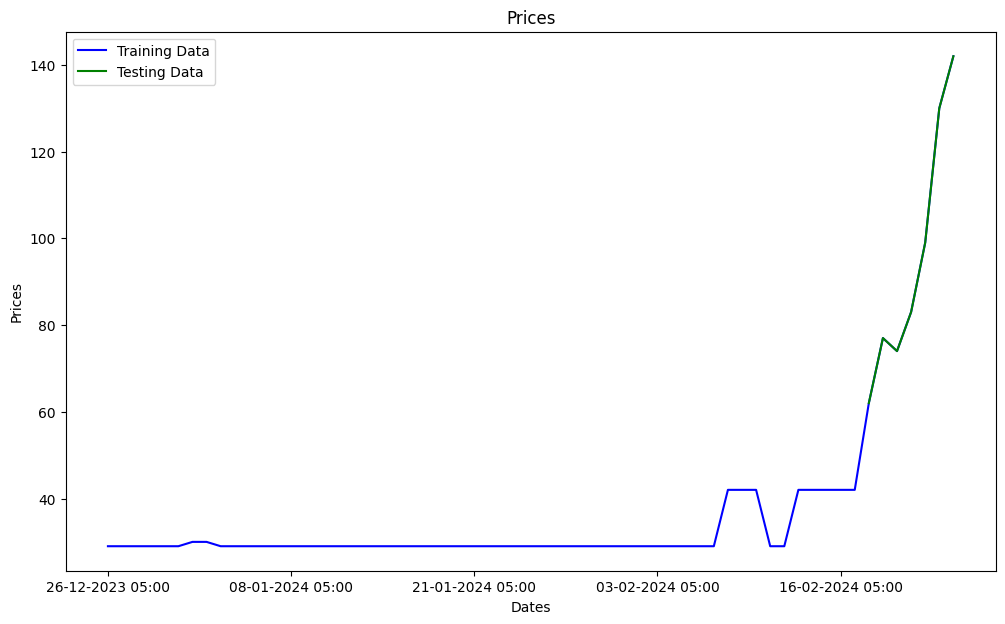

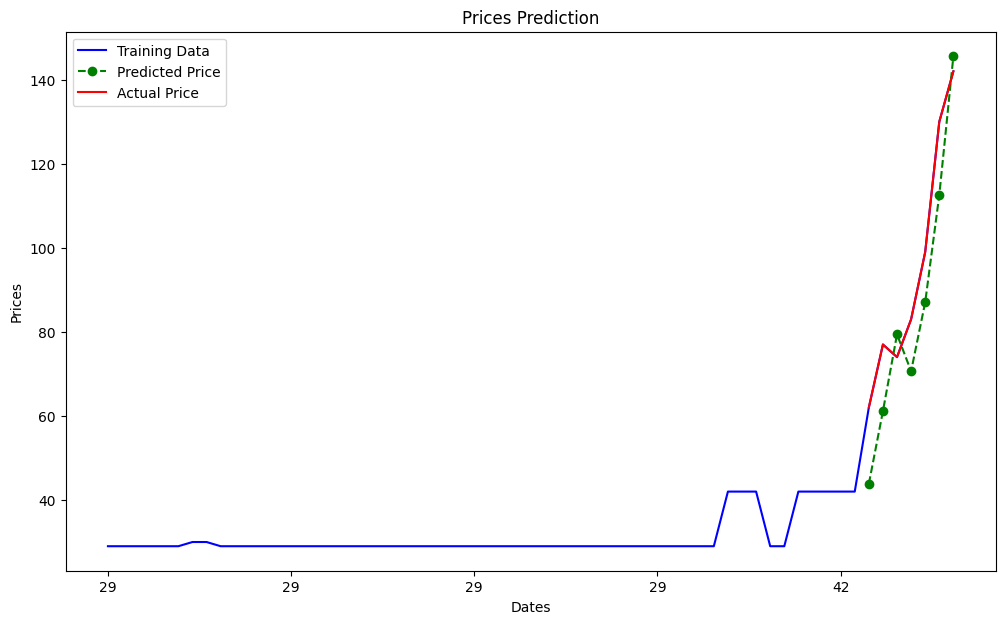

In [150]:
df_fll = pd.read_csv("flight_data_and_price_history_fll_to_SAT.csv")
df_fll.head()
df_price_fll = df_fll['Price']
df_price_fll.tail()
train_data_fll, test_data_fll = df_fll[0:int(len(df_fll)*0.9)], df_fll[int(len(df_fll)*0.9):]
plt.figure(figsize=(12,7))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_fll['Price'], 'blue', label='Training Data')
plt.plot(test_data_fll['Price'], 'green', label='Testing Data')
plt.xticks(np.arange(0,61, 13), df_fll['Date'][0:61:13])
plt.legend()
train_ar_fll = train_data_fll['Price'].values
test_ar_fll = test_data_fll['Price'].values
import statsmodels.api as sm

history_fll = [x for x in train_ar_fll]
print(type(history_fll))
predictions_fll = list()
for t in range(len(test_ar_fll)):
    model_fll = sm.tsa.arima.ARIMA(history_fll, order=(5,1,0))
    model_fit_fll = model_fll.fit()
    output_fll = model_fit_fll.forecast()
    yhat = output_fll[0]
    predictions_fll.append(yhat)
    obs = test_ar_fll[t]
    history_fll.append(obs)
error = mean_squared_error(test_ar_fll, predictions_fll)
print('Testing Mean Squared Error: %.3f' % error)
#error2 = smape_kun(test_ar_fll, predictions_fll)
#print('Symmetric mean absolute error: %.3f' % error2)

mae_2 = mean_absolute_error(test_ar_fll, predictions_fll)
print('MAE: '+str(mae_2))
rmse_2 = math.sqrt(mean_squared_error(test_ar_fll, predictions_fll))
print('RMSE: '+str(rmse_2))
mape_2 = np.mean(np.abs(predictions_fll - test_ar_fll)/np.abs(test_ar_fll))
print('MAPE: '+str(mape_2))
plt.figure(figsize=(12,7))
plt.plot(df_fll['Price'], 'green', color='blue', label='Training Data')
plt.plot(test_data_fll.index, predictions_fll, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_fll.index, test_data_fll['Price'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,61, 13), df_fll['Price'][0:61:13])
plt.legend()

<class 'list'>
Testing Mean Squared Error: 1113.205
MAE: 26.817630752493447
RMSE: 33.36473115900699
MAPE: 0.1977070254268208


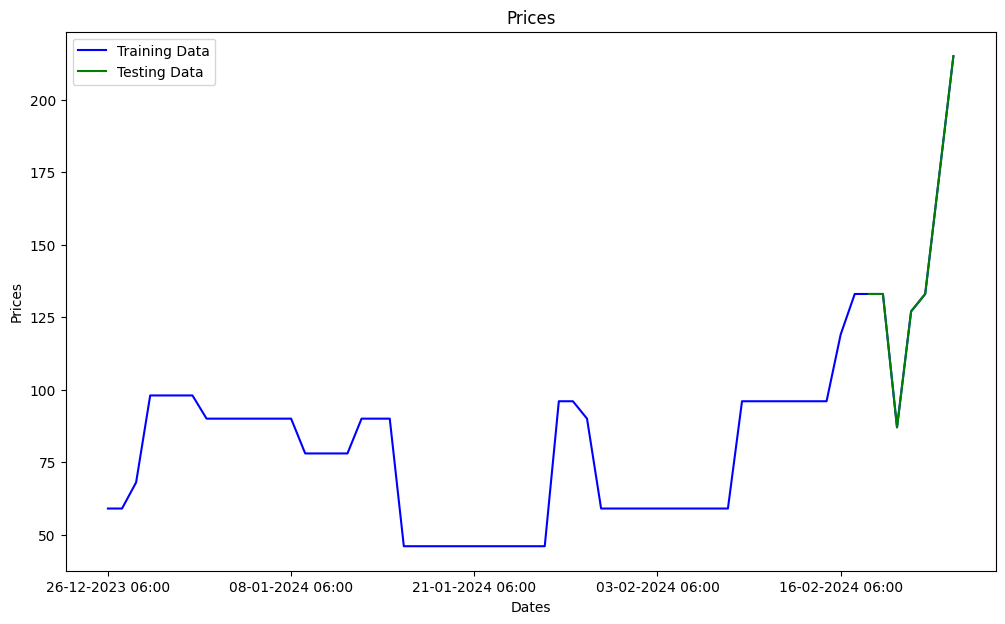

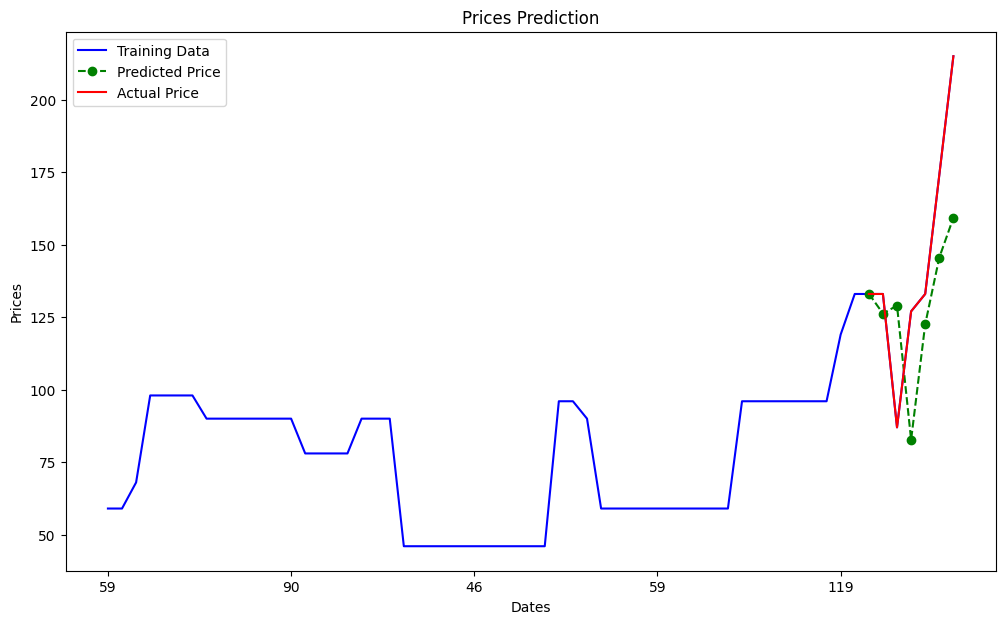

In [151]:
df_dfw = pd.read_csv("flight_data_and_price_history_dfw_to_SAT.csv")
df_dfw.head()
df_price_dfw = df_dfw['Price']
df_price_dfw.tail()
train_data_dfw, test_data_dfw = df_dfw[0:int(len(df_dfw)*0.9)], df_dfw[int(len(df_dfw)*0.9):]
plt.figure(figsize=(12,7))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_dfw['Price'], 'blue', label='Training Data')
plt.plot(test_data_dfw['Price'], 'green', label='Testing Data')
plt.xticks(np.arange(0,61, 13), df_dfw['Date'][0:61:13])
plt.legend()
train_ar_dfw = train_data_dfw['Price'].values
test_ar_dfw = test_data_dfw['Price'].values
import statsmodels.api as sm

history_dfw = [x for x in train_ar_dfw]
print(type(history_dfw))
predictions_dfw = list()
for t in range(len(test_ar_dfw)):
    model_dfw = sm.tsa.arima.ARIMA(history_dfw, order=(5,1,0))
    model_fit_dfw = model_dfw.fit()
    output_dfw = model_fit_dfw.forecast()
    yhat = output_dfw[0]
    predictions_dfw.append(yhat)
    obs = test_ar_dfw[t]
    history_dfw.append(obs)
error = mean_squared_error(test_ar_dfw, predictions_dfw)
print('Testing Mean Squared Error: %.3f' % error)
#error2 = smape_kun(test_ar_dfw, predictions_dfw)
#print('Symmetric mean absolute error: %.3f' % error2)

mae_2 = mean_absolute_error(test_ar_dfw, predictions_dfw)
print('MAE: '+str(mae_2))
rmse_2 = math.sqrt(mean_squared_error(test_ar_dfw, predictions_dfw))
print('RMSE: '+str(rmse_2))
mape_2 = np.mean(np.abs(predictions_dfw - test_ar_dfw)/np.abs(test_ar_dfw))
print('MAPE: '+str(mape_2))
plt.figure(figsize=(12,7))
plt.plot(df_dfw['Price'], 'green', color='blue', label='Training Data')
plt.plot(test_data_dfw.index, predictions_dfw, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_dfw.index, test_data_dfw['Price'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,61, 13), df_dfw['Price'][0:61:13])
plt.legend()

<class 'list'>
Testing Mean Squared Error: 1083.644
MAE: 22.064388283266346
RMSE: 32.91875468066155
MAPE: 0.13076395891150092


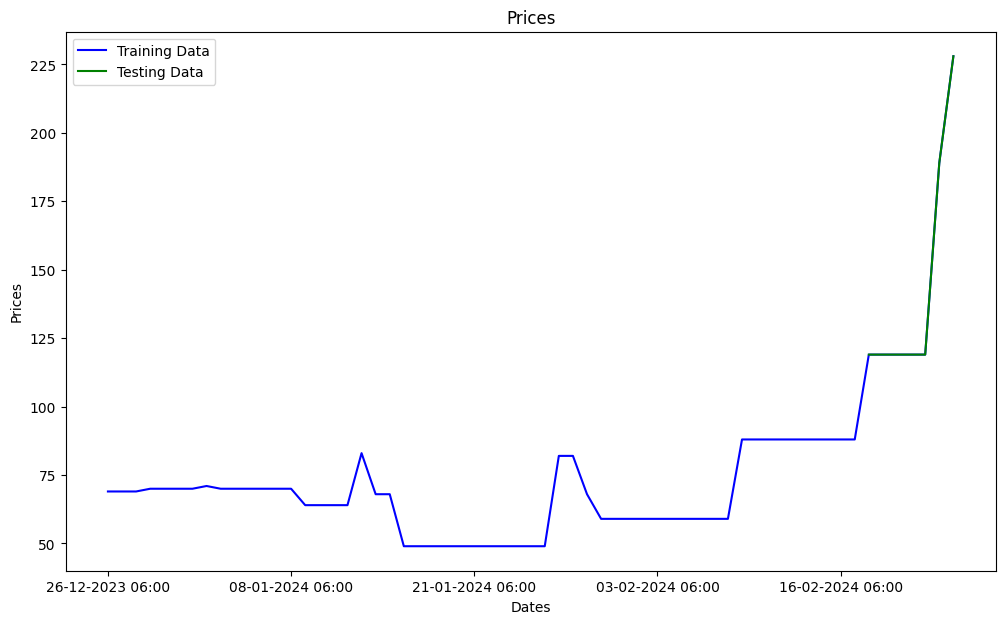

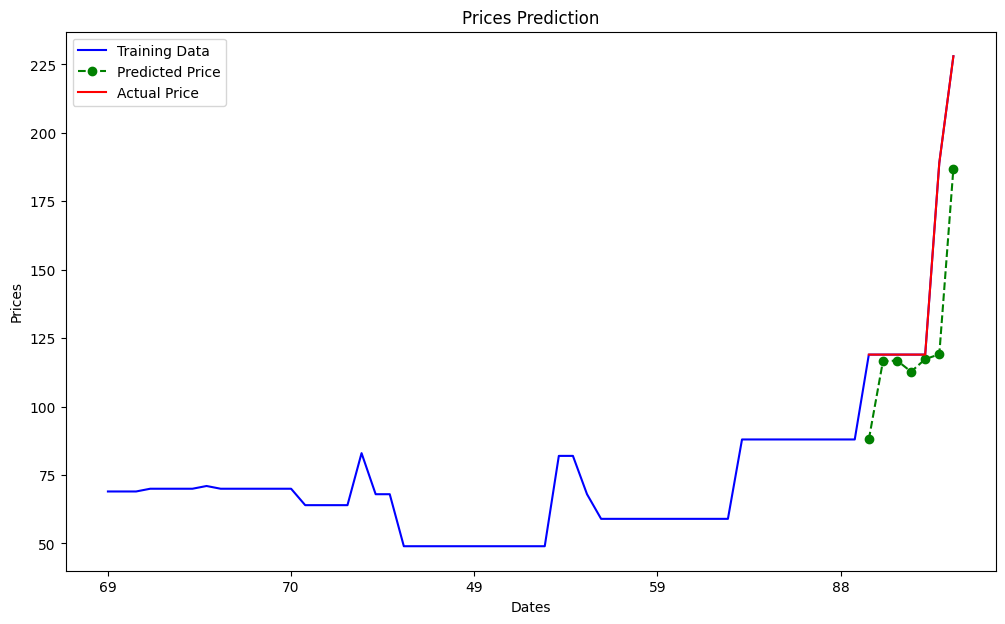

In [152]:
df_iah = pd.read_csv("flight_data_and_price_history_iah_to_SAT.csv")
df_iah.head()
df_price_iah = df_iah['Price']
df_price_iah.tail()
train_data_iah, test_data_iah = df_iah[0:int(len(df_iah)*0.9)], df_iah[int(len(df_iah)*0.9):]
plt.figure(figsize=(12,7))
plt.title('Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df_iah['Price'], 'blue', label='Training Data')
plt.plot(test_data_iah['Price'], 'green', label='Testing Data')
plt.xticks(np.arange(0,61, 13), df_iah['Date'][0:61:13])
plt.legend()
train_ar_iah = train_data_iah['Price'].values
test_ar_iah = test_data_iah['Price'].values
import statsmodels.api as sm

history_iah = [x for x in train_ar_iah]
print(type(history_iah))
predictions_iah = list()
for t in range(len(test_ar_iah)):
    model_iah = sm.tsa.arima.ARIMA(history_iah, order=(5,1,0))
    model_fit_iah = model_iah.fit()
    output_iah = model_fit_iah.forecast()
    yhat = output_iah[0]
    predictions_iah.append(yhat)
    obs = test_ar_iah[t]
    history_iah.append(obs)
error = mean_squared_error(test_ar_iah, predictions_iah)
print('Testing Mean Squared Error: %.3f' % error)
#error2 = smape_kun(test_ar_iah, predictions_iah)
#print('Symmetric mean absolute error: %.3f' % error2)

mae_2 = mean_absolute_error(test_ar_iah, predictions_iah)
print('MAE: '+str(mae_2))
rmse_2 = math.sqrt(mean_squared_error(test_ar_iah, predictions_iah))
print('RMSE: '+str(rmse_2))
mape_2 = np.mean(np.abs(predictions_iah - test_ar_iah)/np.abs(test_ar_iah))
print('MAPE: '+str(mape_2))
plt.figure(figsize=(12,7))
plt.plot(df_iah['Price'], 'green', color='blue', label='Training Data')
plt.plot(test_data_iah.index, predictions_iah, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data_iah.index, test_data_iah['Price'], color='red', label='Actual Price')
plt.title('Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.xticks(np.arange(0,61, 13), df_iah['Price'][0:61:13])
plt.legend()

In [153]:
forecast_aus = model_fit_aus.forecast(steps=250)

In [154]:
forecast_data_aus = forecast_aus

In [155]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np

# Load the dataset
file_path = 'flight_data_and_price_history_aus_to_SAT.csv'
data = pd.read_csv(file_path)


# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')

# Find the last date from the dataset
last_date = data['Date'].iloc[-1]

# Generate new dates for forecast data starting the day after the last date in the dataset
new_dates = [last_date + timedelta(days=x+1) for x in range(len(forecast_data_aus))]

# Create a new DataFrame with the forecast data
forecast_df = pd.DataFrame({
    'Date': new_dates,
    'Price': forecast_data_aus,
    'From': 'AUS'
})

# Append the forecast data to the existing dataset
updated_data = data.append(forecast_df, ignore_index=True)

# Save the updated dataset to a new CSV file
updated_file_path = 'updated_flight_data_and_price_history_aus_to_SAT.csv'
updated_data.to_csv(updated_file_path, index=False, date_format='%d-%m-%Y %H:%M')

updated_file_path


'updated_flight_data_and_price_history_aus_to_SAT.csv'

In [156]:
forecast_bos = model_fit_bos.forecast(steps=250)
forecast_data_bos = forecast_bos
# Load the dataset
file_path = 'flight_data_and_price_history_bos_to_SAT.csv'
data = pd.read_csv(file_path)


# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')

# Find the last date from the dataset
last_date = data['Date'].iloc[-1]

# Generate new dates for forecast data starting the day after the last date in the dataset
new_dates = [last_date + timedelta(days=x+1) for x in range(len(forecast_data_bos))]

# Create a new DataFrame with the forecast data
forecast_df = pd.DataFrame({
    'Date': new_dates,
    'Price': forecast_data_bos,
    'From': 'bos'
})

# Append the forecast data to the existing dataset
updated_data = data.append(forecast_df, ignore_index=True)

# Save the updated dataset to a new CSV file
updated_file_path = 'updated_flight_data_and_price_history_bos_to_SAT.csv'
updated_data.to_csv(updated_file_path, index=False, date_format='%d-%m-%Y %H:%M')

updated_file_path

'updated_flight_data_and_price_history_bos_to_SAT.csv'

In [157]:
forecast_slc = model_fit_slc.forecast(steps=250)
forecast_data_slc = forecast_slc
# Load the dataset
file_path = 'flight_data_and_price_history_slc_to_SAT.csv'
data = pd.read_csv(file_path)


# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')

# Find the last date from the dataset
last_date = data['Date'].iloc[-1]

# Generate new dates for forecast data starting the day after the last date in the dataset
new_dates = [last_date + timedelta(days=x+1) for x in range(len(forecast_data_slc))]

# Create a new DataFrame with the forecast data
forecast_df = pd.DataFrame({
    'Date': new_dates,
    'Price': forecast_data_slc,
    'From': 'slc'
})

# Append the forecast data to the existing dataset
updated_data = data.append(forecast_df, ignore_index=True)

# Save the updated dataset to a new CSV file
updated_file_path = 'updated_flight_data_and_price_history_slc_to_SAT.csv'
updated_data.to_csv(updated_file_path, index=False, date_format='%d-%m-%Y %H:%M')

updated_file_path

'updated_flight_data_and_price_history_slc_to_SAT.csv'

In [158]:
forecast_sfo = model_fit_sfo.forecast(steps=250)
forecast_data_sfo = forecast_sfo
# Load the dataset
file_path = 'flight_data_and_price_history_sfo_to_SAT.csv'
data = pd.read_csv(file_path)


# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')

# Find the last date from the dataset
last_date = data['Date'].iloc[-1]

# Generate new dates for forecast data starting the day after the last date in the dataset
new_dates = [last_date + timedelta(days=x+1) for x in range(len(forecast_data_sfo))]

# Create a new DataFrame with the forecast data
forecast_df = pd.DataFrame({
    'Date': new_dates,
    'Price': forecast_data_sfo,
    'From': 'sfo'
})

# Append the forecast data to the existing dataset
updated_data = data.append(forecast_df, ignore_index=True)

# Save the updated dataset to a new CSV file
updated_file_path = 'updated_flight_data_and_price_history_sfo_to_SAT.csv'
updated_data.to_csv(updated_file_path, index=False, date_format='%d-%m-%Y %H:%M')

updated_file_path

'updated_flight_data_and_price_history_sfo_to_SAT.csv'

In [159]:
forecast_sea = model_fit_sea.forecast(steps=250)
forecast_data_sea = forecast_sea
# Load the dataset
file_path = 'flight_data_and_price_history_sea_to_SAT.csv'
data = pd.read_csv(file_path)


# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')

# Find the last date from the dataset
last_date = data['Date'].iloc[-1]

# Generate new dates for forecast data starting the day after the last date in the dataset
new_dates = [last_date + timedelta(days=x+1) for x in range(len(forecast_data_sea))]

# Create a new DataFrame with the forecast data
forecast_df = pd.DataFrame({
    'Date': new_dates,
    'Price': forecast_data_sea,
    'From': 'sea'
})

# Append the forecast data to the existing dataset
updated_data = data.append(forecast_df, ignore_index=True)

# Save the updated dataset to a new CSV file
updated_file_path = 'updated_flight_data_and_price_history_sea_to_SAT.csv'
updated_data.to_csv(updated_file_path, index=False, date_format='%d-%m-%Y %H:%M')

updated_file_path

'updated_flight_data_and_price_history_sea_to_SAT.csv'

In [160]:
forecast_mia = model_fit_mia.forecast(steps=250)
forecast_data_mia = forecast_mia
# Load the dataset
file_path = 'flight_data_and_price_history_mia_to_SAT.csv'
data = pd.read_csv(file_path)


# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')

# Find the last date from the dataset
last_date = data['Date'].iloc[-1]

# Generate new dates for forecast data starting the day after the last date in the dataset
new_dates = [last_date + timedelta(days=x+1) for x in range(len(forecast_data_mia))]

# Create a new DataFrame with the forecast data
forecast_df = pd.DataFrame({
    'Date': new_dates,
    'Price': forecast_data_mia,
    'From': 'mia'
})

# Append the forecast data to the existing dataset
updated_data = data.append(forecast_df, ignore_index=True)

# Save the updated dataset to a new CSV file
updated_file_path = 'updated_flight_data_and_price_history_mia_to_SAT.csv'
updated_data.to_csv(updated_file_path, index=False, date_format='%d-%m-%Y %H:%M')

updated_file_path

'updated_flight_data_and_price_history_mia_to_SAT.csv'

In [161]:
forecast_jfk = model_fit_jfk.forecast(steps=250)
forecast_data_jfk = forecast_jfk
# Load the dataset
file_path = 'flight_data_and_price_history_jfk_to_SAT.csv'
data = pd.read_csv(file_path)


# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')

# Find the last date from the dataset
last_date = data['Date'].iloc[-1]

# Generate new dates for forecast data starting the day after the last date in the dataset
new_dates = [last_date + timedelta(days=x+1) for x in range(len(forecast_data_jfk))]

# Create a new DataFrame with the forecast data
forecast_df = pd.DataFrame({
    'Date': new_dates,
    'Price': forecast_data_jfk,
    'From': 'jfk'
})

# Append the forecast data to the existing dataset
updated_data = data.append(forecast_df, ignore_index=True)

# Save the updated dataset to a new CSV file
updated_file_path = 'updated_flight_data_and_price_history_jfk_to_SAT.csv'
updated_data.to_csv(updated_file_path, index=False, date_format='%d-%m-%Y %H:%M')

updated_file_path

'updated_flight_data_and_price_history_jfk_to_SAT.csv'

In [162]:
forecast_iah = model_fit_iah.forecast(steps=250)
forecast_data_iah = forecast_iah
# Load the dataset
file_path = 'flight_data_and_price_history_iah_to_SAT.csv'
data = pd.read_csv(file_path)


# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')

# Find the last date from the dataset
last_date = data['Date'].iloc[-1]

# Generate new dates for forecast data starting the day after the last date in the dataset
new_dates = [last_date + timedelta(days=x+1) for x in range(len(forecast_data_iah))]

# Create a new DataFrame with the forecast data
forecast_df = pd.DataFrame({
    'Date': new_dates,
    'Price': forecast_data_iah,
    'From': 'iah'
})

# Append the forecast data to the existing dataset
updated_data = data.append(forecast_df, ignore_index=True)

# Save the updated dataset to a new CSV file
updated_file_path = 'updated_flight_data_and_price_history_iah_to_SAT.csv'
updated_data.to_csv(updated_file_path, index=False, date_format='%d-%m-%Y %H:%M')

updated_file_path

'updated_flight_data_and_price_history_iah_to_SAT.csv'

In [163]:
forecast_fll = model_fit_fll.forecast(steps=250)
forecast_data_fll = forecast_fll
# Load the dataset
file_path = 'flight_data_and_price_history_fll_to_SAT.csv'
data = pd.read_csv(file_path)


# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')

# Find the last date from the dataset
last_date = data['Date'].iloc[-1]

# Generate new dates for forecast data starting the day after the last date in the dataset
new_dates = [last_date + timedelta(days=x+1) for x in range(len(forecast_data_fll))]

# Create a new DataFrame with the forecast data
forecast_df = pd.DataFrame({
    'Date': new_dates,
    'Price': forecast_data_fll,
    'From': 'fll'
})

# Append the forecast data to the existing dataset
updated_data = data.append(forecast_df, ignore_index=True)

# Save the updated dataset to a new CSV file
updated_file_path = 'updated_flight_data_and_price_history_fll_to_SAT.csv'
updated_data.to_csv(updated_file_path, index=False, date_format='%d-%m-%Y %H:%M')

updated_file_path

'updated_flight_data_and_price_history_fll_to_SAT.csv'

In [164]:
forecast_dfw = model_fit_dfw.forecast(steps=250)
forecast_data_dfw = forecast_dfw
# Load the dataset
file_path = 'flight_data_and_price_history_dfw_to_SAT.csv'
data = pd.read_csv(file_path)


# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y %H:%M')

# Find the last date from the dataset
last_date = data['Date'].iloc[-1]

# Generate new dates for forecast data starting the day after the last date in the dataset
new_dates = [last_date + timedelta(days=x+1) for x in range(len(forecast_data_dfw))]

# Create a new DataFrame with the forecast data
forecast_df = pd.DataFrame({
    'Date': new_dates,
    'Price': forecast_data_dfw,
    'From': 'dfw'
})

# Append the forecast data to the existing dataset
updated_data = data.append(forecast_df, ignore_index=True)

# Save the updated dataset to a new CSV file
updated_file_path = 'updated_flight_data_and_price_history_dfw_to_SAT.csv'
updated_data.to_csv(updated_file_path, index=False, date_format='%d-%m-%Y %H:%M')

updated_file_path

'updated_flight_data_and_price_history_dfw_to_SAT.csv'